# Building Makemore Part 2: Multi-Layer Perceptron

[Reference Video](https://youtu.be/TCH_1BHY58I?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

[Reference Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Part 1: Explore the Dataset

In [196]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [197]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [198]:
len(words)

32033

## Part 2: Label the Dataset

In [199]:
# mappings from letter to index, and index to letter
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [200]:
# build an adjustable block-size
block_size = 3
X, Y = [], [] # inputs and labels
for w in words[:5]:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [201]:
X[:4], Y[:4]

(tensor([[ 0,  0,  0],
         [ 0,  0,  5],
         [ 0,  5, 13],
         [ 5, 13, 13]]),
 tensor([ 5, 13, 13,  1]))

## Part 3: Semantic Character Representation in a 2-D Space

### 3.1 Image of neural net from [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) by Bergio et. al.

![Image of neural net for reference](./network.png)


In [202]:
# build a character embedding in a 2-dim space
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,2, generator=g)
C.shape, C[:4]

(torch.Size([27, 2]),
 tensor([[ 1.5674, -0.2373],
         [-0.0274, -1.1008],
         [ 0.2859, -0.0296],
         [-1.5471,  0.6049]]))

### 3.2 Pull a name out of the Character Embedding

In [203]:
# index the character embedding using a word
name = []
for w in words[:1]:
    for ch in w + '.':
        ix = stoi[ch]
        name.append(ix) # indices of name 'emma
    
C[name] # embedding of name 'emma'

tensor([[-0.4713,  0.7868],
        [ 2.4448, -0.6701],
        [ 2.4448, -0.6701],
        [-0.0274, -1.1008],
        [ 1.5674, -0.2373]])

### 3.3: Embedding the entire data set

In `emb`, the embedding of our entire dataset of characater sequences (trigrams, in the most naive approach), the first axis denotes each character sequence used as context (ex. previous 3 letters). Then, the second axis indexes which character in the sequence (first, second, or third). And finally, the third axis denotes the elmenents of the n-dimensional space of character embeddings

In [204]:
# embed the entire dataset
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [205]:

W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)

In [206]:
# emb @ W1 + b1 # What we want to do.

### 3.4: Wrangling the embedding data (Naive approach)

In [207]:
# Naive approach to concatentating embeddings of each trigram into an (n, 6) array
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[:10]


tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

In [208]:
# unbind the trigrams, achieve same as above
torch.cat(torch.unbind(emb, 1), 1)[:10] # (n, 6) shape instead of (n, 3, 2)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        [-0.4713,  0.7868,  2.4448, -0.6701,  2.4448, -0.6701],
        [ 2.4448, -0.6701,  2.4448, -0.6701, -0.0274, -1.1008],
        [ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.0725,  0.7276],
        [ 1.5674, -0.2373, -1.0725,  0.7276, -0.0707,  2.4968],
        [-1.0725,  0.7276, -0.0707,  2.4968,  0.6772, -0.8404],
        [-0.0707,  2.4968,  0.6772, -0.8404, -0.1158, -1.2078]])

#### Summary of 3.4: 

We started off with a tensor of dimension `(n, block_size, embedding_space_dim)`.

Then, for each n-gram or block of characters, we used `torch.unbind` and then `torch.cat` to concatentate each embedding along eachother.

So, if we now use a trigram with character embeddings in a 2-dimensional space, we will then have a 6-element long input to the network.

### 3.5: More efficient approach using `tensor.view`

[ezyang's blog post on PyTorch internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [209]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [210]:
a.view(2,9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [211]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [212]:
# Reshape the embedding efficiently
emb = C[X]

emb = emb.view(emb.shape[0], 6) 
# OR
emb = emb.view(emb.shape[0], -1) # -1 means "whatever is needed to make the shape work"

## Part 2: Building the network

### 2.1: Hidden Layer

Since we already reshaped our data, the input layer is done.

Now we will create the hidden layer.

In [213]:
emb @ W1 + b1 # Works now !

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-4.3248e+00,  7.4938e+00, -1.6386e+00,  ..., -5.1557e+00,
         -3.3276e+00, -3.2464e+00],
        [-1.4951e+00,  5.6195e+00,  2.5079e+00,  ..., -1.0607e+00,
         -5.2543e-01,  3.4893e+00],
        [-1.4982e+00,  8.5941e+00,  1.8897e+00,  ...,  2.4983e+00,
          6.9596e+00,  2.6822e+00]])

In [214]:
# Hidden layer activation using tanh
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # hidden layer activation
h.shape

torch.Size([32, 100])

In [215]:
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)

In [216]:
logits = h @ W2 + b2 # log counts
logits.shape

torch.Size([32, 27])

Text(0.5, 0, 'Probability of each character output')

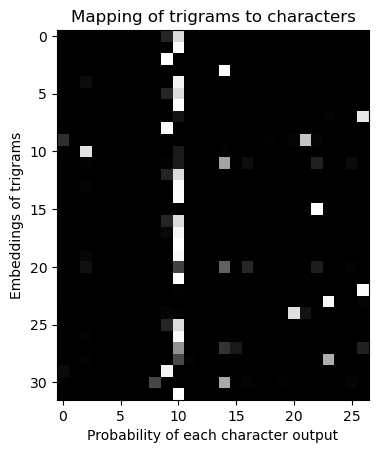

In [217]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
plt.imshow(probs.detach().numpy(), cmap='gray')
plt.title("Mapping of trigrams to characters")
plt.ylabel("Embeddings of trigrams")
plt.xlabel("Probability of each character output")

In [218]:
probs[:, 1] # probabiility of letter 'a' for each trigram

tensor([2.0283e-10, 9.0695e-12, 1.5368e-13, 3.1758e-10, 3.0845e-09, 2.0283e-10,
        3.0830e-12, 3.2550e-11, 1.6815e-12, 2.0269e-09, 5.3863e-08, 2.8552e-06,
        2.0283e-10, 2.6391e-09, 6.2336e-07, 3.5843e-08, 2.0283e-10, 2.8360e-10,
        2.0670e-09, 1.7086e-08, 1.6384e-09, 4.1033e-14, 8.1859e-12, 5.6464e-15,
        1.5201e-10, 2.0283e-10, 9.9325e-10, 5.6630e-08, 2.7953e-11, 6.6081e-15,
        9.7404e-10, 9.1782e-12])

## Part 3: Loss function

We will use the negative log likelihood as the loss function, to east computation and so that minimizing the loss function means optimizing the network.

Previously, we manually calculated each step of the negative log likelihood, now we will use Torch's `cross_entropy` function that takes in the logits, and outputs the negative log likelihood as shown below. This is also much more efficient, and better able to handle a larger range of inputs (without getting exploding `.exp()` numbers)

In [219]:
-probs[torch.arange(32), Y].log().mean()

tensor(17.7697)

In [220]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

## Part 4: Training the net

#### Definitions:

<strong>Batch Gradient Descent (super slow, but accurate)</strong>: Gradient Descent in which every training example is used to characterize the gradient of the loss function, in each step in training. 

<strong>Stochastic Gradient Descent (fast, but inaccurate)</strong> Gradient descent in which only one training example is used to approximate the gradient of the loss function at each step of training. 

<strong>Mini-Batch Gradient Descent(balance of speed and accuracy)</strong> Gradient descent in which a mini-batch of samples is used to approximate the gradient of the loss function at each step of training.

#### Approach:

We will first try full-batch gradient descent, see how slow it is, then use mini-batches.

### 4.1: Gradient descent (full-batch)

This will use the entire dataset for each forward pass and backward pass. This is extremely inefficient and we will optimize this later.

In [221]:
# use whole dataset
block_size = 3
X, Y = [], [] # inputs and labels
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # shift context

X = torch.tensor(X)
Y = torch.tensor(Y)

In [222]:
# redo everything compactly
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [223]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [224]:
%%timeit -r 1 -n 1
eta = 0.1
epochs = 10
for epoch in range(epochs):
    emb = C[X]
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y)
    print(f"Epoch {epoch+1}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 1: 19.505
Epoch 2: 17.084
Epoch 3: 15.777
Epoch 4: 14.833
Epoch 5: 14.003
Epoch 6: 13.253
Epoch 7: 12.580
Epoch 8: 11.983
Epoch 9: 11.471
Epoch 10: 11.052
4.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 4.2: Mini-batch gradient descent

In [225]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [226]:
%%timeit -r 1 -n 1

eta = 0.1
epochs = 100
batch_size = 32


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 19.718
Epoch 1: 16.102
Epoch 2: 18.878
Epoch 3: 17.294
Epoch 4: 16.387
Epoch 5: 13.388
Epoch 6: 12.767
Epoch 7: 12.833
Epoch 8: 11.613
Epoch 9: 11.036
Epoch 10: 12.184
Epoch 11: 10.814
Epoch 12: 9.243
Epoch 13: 10.355
Epoch 14: 9.972
Epoch 15: 7.437
Epoch 16: 7.387
Epoch 17: 8.686
Epoch 18: 8.770
Epoch 19: 7.508
Epoch 20: 8.310
Epoch 21: 10.582
Epoch 22: 6.665
Epoch 23: 7.132
Epoch 24: 6.960
Epoch 25: 6.670
Epoch 26: 7.083
Epoch 27: 6.536
Epoch 28: 6.545
Epoch 29: 7.019
Epoch 30: 5.647
Epoch 31: 6.699
Epoch 32: 5.956
Epoch 33: 5.014
Epoch 34: 6.629
Epoch 35: 7.140
Epoch 36: 5.089
Epoch 37: 3.788
Epoch 38: 5.882
Epoch 39: 5.524
Epoch 40: 6.594
Epoch 41: 6.720
Epoch 42: 4.877
Epoch 43: 5.352
Epoch 44: 6.538
Epoch 45: 6.277
Epoch 46: 6.069
Epoch 47: 6.005
Epoch 48: 5.746
Epoch 49: 4.948
Epoch 50: 5.028
Epoch 51: 5.066
Epoch 52: 5.375
Epoch 53: 5.728
Epoch 54: 4.443
Epoch 55: 5.263
Epoch 56: 5.875
Epoch 57: 4.396
Epoch 58: 4.528
Epoch 59: 5.832
Epoch 60: 5.205
Epoch 61: 4.672
Epoc

### 4.3: Variable learning rate

In [227]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 3481


In [228]:
eta = 0.0001
epochs = 10000
batch_size = 128


for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    emb = C[X[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 20.249
Epoch 1: 21.095
Epoch 2: 18.974
Epoch 3: 18.481
Epoch 4: 19.555
Epoch 5: 19.306
Epoch 6: 20.475
Epoch 7: 19.230
Epoch 8: 18.797
Epoch 9: 19.479
Epoch 10: 18.948
Epoch 11: 18.973
Epoch 12: 20.178
Epoch 13: 19.568
Epoch 14: 19.279
Epoch 15: 19.876
Epoch 16: 20.040
Epoch 17: 18.825
Epoch 18: 19.536
Epoch 19: 19.023
Epoch 20: 18.773
Epoch 21: 19.215
Epoch 22: 18.646
Epoch 23: 19.224
Epoch 24: 19.561
Epoch 25: 20.086
Epoch 26: 21.269
Epoch 27: 19.753
Epoch 28: 19.770
Epoch 29: 20.776
Epoch 30: 17.839
Epoch 31: 20.162
Epoch 32: 20.686
Epoch 33: 19.036
Epoch 34: 19.604
Epoch 35: 18.477
Epoch 36: 19.755
Epoch 37: 19.300
Epoch 38: 19.719
Epoch 39: 18.989
Epoch 40: 19.021
Epoch 41: 20.307
Epoch 42: 19.847
Epoch 43: 18.639
Epoch 44: 20.435
Epoch 45: 19.532
Epoch 46: 19.774
Epoch 47: 19.839
Epoch 48: 19.341
Epoch 49: 19.658
Epoch 50: 19.871
Epoch 51: 20.160
Epoch 52: 18.157
Epoch 53: 17.609
Epoch 54: 18.894
Epoch 55: 17.785
Epoch 56: 18.835
Epoch 57: 20.294
Epoch 58: 19.130
Epoch 5

### 4.4 Train / validation / test data splits

Typically, we use 80/10/10 percentage splits between training, validation, and test data as to not overfit the validation or test data

Here, we will also increase the size of the hidden layer and see if we can obtain performance increases

In [229]:
def build_dataset(words):
    block_size = 3
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [230]:
# reinitialize meta-parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 10281


In [231]:
eta = 0.001
epochs = 10000
batch_size = 64
losses = []

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad


Epoch 0: 28.664
Epoch 1: 24.904
Epoch 2: 22.384
Epoch 3: 26.499
Epoch 4: 24.258
Epoch 5: 24.509
Epoch 6: 25.890
Epoch 7: 25.839
Epoch 8: 25.894
Epoch 9: 25.545
Epoch 10: 27.243
Epoch 11: 24.912
Epoch 12: 24.233
Epoch 13: 24.595
Epoch 14: 24.867
Epoch 15: 26.583
Epoch 16: 27.461
Epoch 17: 22.765
Epoch 18: 22.120
Epoch 19: 25.752
Epoch 20: 25.189
Epoch 21: 24.109
Epoch 22: 25.340
Epoch 23: 23.144
Epoch 24: 24.160
Epoch 25: 22.805
Epoch 26: 23.070
Epoch 27: 23.447
Epoch 28: 23.029
Epoch 29: 26.047
Epoch 30: 25.922
Epoch 31: 25.271
Epoch 32: 23.017
Epoch 33: 25.795
Epoch 34: 26.730
Epoch 35: 22.194
Epoch 36: 23.938
Epoch 37: 28.042
Epoch 38: 24.701
Epoch 39: 24.482
Epoch 40: 22.693
Epoch 41: 23.254
Epoch 42: 27.490
Epoch 43: 24.564
Epoch 44: 23.375
Epoch 45: 28.275
Epoch 46: 24.366
Epoch 47: 24.481
Epoch 48: 26.249
Epoch 49: 27.390
Epoch 50: 24.557
Epoch 51: 25.739
Epoch 52: 25.797
Epoch 53: 22.646
Epoch 54: 25.092
Epoch 55: 26.704
Epoch 56: 26.733
Epoch 57: 22.968
Epoch 58: 24.558
Epoch 5

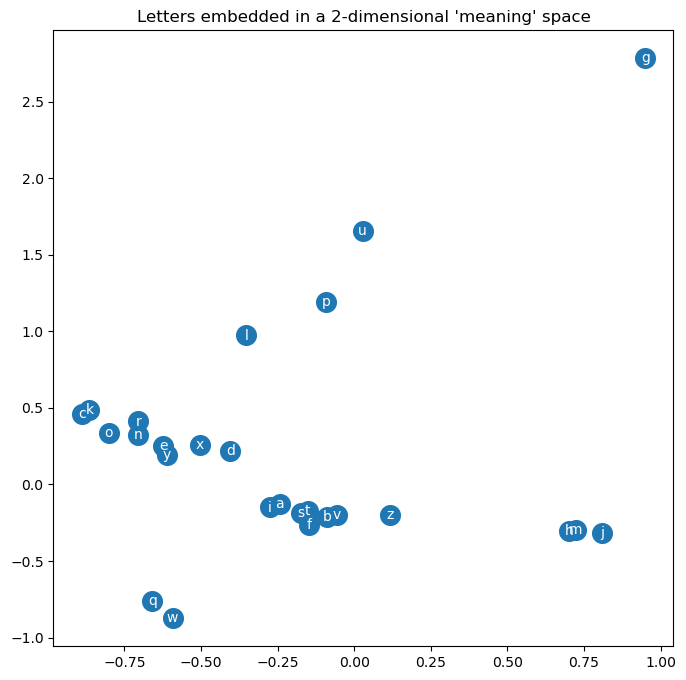

In [232]:

plt.figure(figsize=(8,8))
plt.scatter(C[1:,0].data, C[1:,1].data, s=200)
plt.title("Letters embedded in a 2-dimensional 'meaning' space")
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha="center", va="center", color="white")

## Part 5: 10-dimensional embeddings

Due to a lack of progress in performance from our bigram exercise, we have decided that it is likely that the bottleneck of this net's performance is the limit on how it represents letters in a 2-dimensional space. Thus, we will increase the dimensionality.

In [233]:
def build_dataset(words):
    block_size = 4
    X, Y = [], [] # inputs and labels
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # shift context
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of data
X_valid, Y_valid = build_dataset(words[n1:n2]) # 10% of data
X_test, Y_test = build_dataset(words[n2:]) # 10% of data

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


### 5.2 Final Attempt: Beat Andrej's loss

In [234]:
# hyper-parameters
eta = 0.1
epochs = 50000
batch_size = 32
block_size = 4
emb_dims = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((block_size * emb_dims,400), generator=g)
b1 = torch.randn(400, generator=g)
W2 = torch.randn((400,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print("Total parameters:", sum(p.nelement() for p in parameters))

Total parameters: 27497


In [235]:
etas = []
losses = []

In [236]:

for epoch in range(epochs):
    # construct mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    emb = C[X_train[ix]] # (batch_size)
    # forward pass
    h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
    logits = h @ W2 + b2 # (n, 27)
    loss = F.cross_entropy(logits, Y_train[ix])
    print(f"Epoch {epoch}: {loss.item():.3f}")
    losses.append(loss.log10().item())
    # backward pass
    for p in parameters:
        p.grad = None # resets all gradients
    loss.backward() # updates all gradients in parameters
    for p in parameters:
        p.data += -eta * p.grad if epoch < epochs // 2 else -eta * p.grad * 0.01


Epoch 0: 35.668
Epoch 1: 43.485
Epoch 2: 38.992
Epoch 3: 30.553
Epoch 4: 36.526
Epoch 5: 28.094
Epoch 6: 32.627
Epoch 7: 30.283
Epoch 8: 25.767
Epoch 9: 25.770
Epoch 10: 26.251
Epoch 11: 28.563
Epoch 12: 24.535
Epoch 13: 24.043
Epoch 14: 27.792
Epoch 15: 24.347
Epoch 16: 33.526
Epoch 17: 23.550
Epoch 18: 25.293
Epoch 19: 21.770
Epoch 20: 20.058
Epoch 21: 21.035
Epoch 22: 22.315
Epoch 23: 21.816
Epoch 24: 28.423
Epoch 25: 19.183
Epoch 26: 24.410
Epoch 27: 20.758
Epoch 28: 19.603
Epoch 29: 16.022
Epoch 30: 21.333
Epoch 31: 21.602
Epoch 32: 20.094
Epoch 33: 17.497
Epoch 34: 22.245
Epoch 35: 20.867
Epoch 36: 22.013
Epoch 37: 19.996
Epoch 38: 14.883
Epoch 39: 19.347
Epoch 40: 17.475
Epoch 41: 16.678
Epoch 42: 16.502
Epoch 43: 18.516
Epoch 44: 15.026
Epoch 45: 21.119
Epoch 46: 20.422
Epoch 47: 15.866
Epoch 48: 14.688
Epoch 49: 16.314
Epoch 50: 17.271
Epoch 51: 10.698
Epoch 52: 15.338
Epoch 53: 20.556
Epoch 54: 14.018
Epoch 55: 13.173
Epoch 56: 15.635
Epoch 57: 14.104
Epoch 58: 20.401
Epoch 5

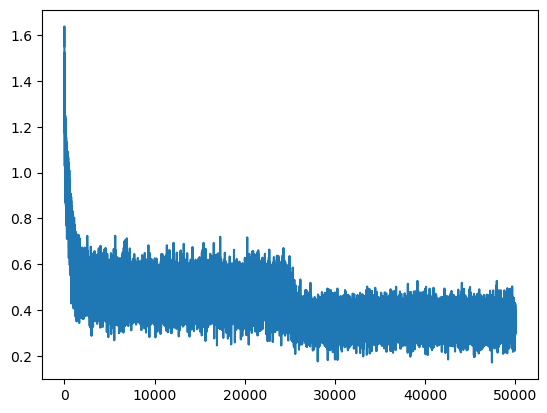

In [237]:
plt.plot(torch.linspace(0, len(losses), len(losses)), losses)

In [238]:
# validation
emb = C[X_valid] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_valid)
print(f"Validation loss: {loss.item():.3f}")

Validation loss: 2.280


In [239]:
# test
emb = C[X_test] # (batch_size)
h = torch.tanh(emb.view(-1, block_size * emb_dims) @ W1 + b1)
logits = h @ W2 + b2 # (n, 27)
loss = F.cross_entropy(logits, Y_test)
print(f"Test loss: {loss.item():.3f}")

Test loss: 2.289


#### Part 6: Feed the model

In [241]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)] # (batch_size)
        h = torch.tanh(emb.view(1, emb_dims * block_size) @ W1 + b1)
        logits = h @ W2 + b2 # (n, 27)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

daiiennay.
jaytian.
toolleigheellilia.
elize.
tionge.
syuoru.
losh.
narin.
aldigh.
lazarolii.
monndinaulen.
aubolh.
allis.
khay.
bizio.
vysah.
elacil.
vact.
khrun.
jaylynn.
